# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University. 

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL 

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

## Download Dataset

In [1]:
# # get dataset from huggingface hub
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
!unzip ./MLHW_6/faces.zip -d .

In [4]:
!/opt/anaconda3/bin/python -m pip install --upgrade pip

In [2]:
# Stylegan2
!pip3 install stylegan2_pytorch

     |████████████████████████████████| 493 kB 789 kB/s eta 0:00:01
     |████████████████████████████████| 17.8 MB 7.1 kB/s eta 0:00:01
     |████████████████████████████████| 87 kB 186 kB/s eta 0:00:01
     |████████████████████████████████| 51 kB 68 kB/s  eta 0:00:01
     |████████████████████████████████| 210 kB 333 kB/s eta 0:00:01
     |████████████████████████████████| 53 kB 220 kB/s eta 0:00:01
     |████████████████████████████████| 5.2 MB 283 kB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 243 kB/s eta 0:00:01
     |████████████████████████████████| 55 kB 278 kB/s eta 0:00:01
     |████████████████████████████████| 78 kB 183 kB/s eta 0:00:01
     |████████████████████████████████| 60 kB 302 kB/s eta 0:00:01
     |████████████████████████████████| 12.6 MB 390 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 386 kB/s eta 0:00:01
  Created wheel for vector-quantize-pytorch: filename=vector_quantize_pytorch-0.1.0-py3-none-any.whl size=2574 sha256=b04

In [3]:
# Training progress bar
!pip3 install -q qqdm

## Other setting

In [1]:
from qqdm.notebook import qqdm

In [2]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2022)
workspace_dir = '.'

# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [3]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

## Show the image
Show some sample in the dataset

In [4]:
os.path.join(workspace_dir, 'faces')

'./faces'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


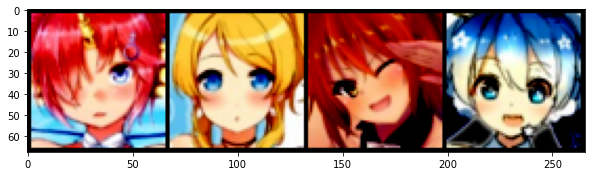

In [5]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
images
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [6]:
!nvidia-smi

Fri Apr  8 23:27:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   57C    P0    43W / 180W |    356MiB /  8192MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!export CUDA_VISIBLE_DEVICES=0

In [10]:
# !stylegan2_pytorch --data ./faces --name stylegan2 --models_dir ./models --results_dir ./results --image-size 64 --network-capacity 32 --num-train-steps 100000
!stylegan2_pytorch --data ./faces --name stylegan2 --models_dir ./models --results_dir ./results --image-size 64 --num-train-steps 100000

stylegan2<./faces>: 100%|████████████| 100000/100000 [28:37:43<00:00,  1.03s/it]


continuing from previous epoch - 100
loading from version 1.8.8


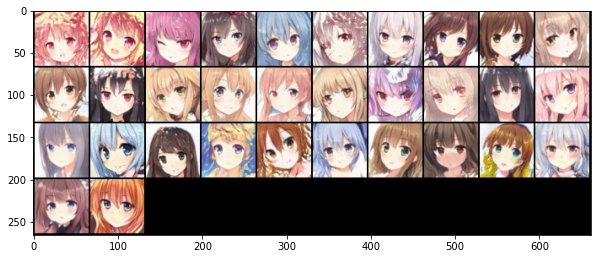

In [11]:
# Generate 1000 images and make a grid to save them.
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = '.',   # path to where you invoked the command line tool
    name = 'stylegan2' # the project name, defaults to 'default'
)


n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.75)  # pass through mapping network

# Show 32 of the images.
imgs_sample = loader.styles_to_images(styles[:32])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [12]:
# Save the generated images.
os.makedirs('./output/', exist_ok=True)
eval_batch_size = 100

for i in range(10):
    images = loader.styles_to_images(styles[i*eval_batch_size:(i+1)*eval_batch_size])
    for j in range(eval_batch_size):
        save_image(images[j], f'./output/{i*eval_batch_size+j+1}.jpg') # save your images, or do whatever you desire

# Compress the images.
%cd ./output
!tar -zcf ../images.tgz *.jpg
%cd ..

/home/chinghsuan/下載/HW6/output
/home/chinghsuan/下載/HW6
